# Gaussian Process Regressor with positive weights constraint

In [1]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import Bounds, LinearConstraint, minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Kernel
from sklearn.metrics import pairwise_distances
from sklearn.utils.validation import check_array

In [2]:
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X)**2)
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=35, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [3]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds="fixed")
alpha = 1e-1

In [4]:
gp1 = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
gp1.fit(X_train, y_train)
prediction_1 = gp1.predict(X)

In [5]:
class PositiveGaussianProcessRegressor:
    def __init__(self, kernel: Kernel, alpha: float = 1e-10, constrained: bool = False):
        """
        Positive Gaussian Process Regressor.

        Parameters:
        - kernel (Kernel): An sklearn Gaussian process kernel.
        - alpha (float): Regularization parameter. Default is 1e-10.
        - constrained (bool): Whether to enforce sum-to-one constraints on weights. Default is False.
        """
        self.kernel = kernel
        self.alpha = alpha
        self.constrained = constrained

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the model to the training data.

        Parameters:
        - X (np.ndarray): Training input data, shape (n_samples, n_features).
        - y (np.ndarray): Target values, shape (n_samples,).
        """
        self.X = check_array(X, ensure_2d=True, force_all_finite=True)
        self.y = check_array(y, ensure_2d=False, force_all_finite=True)

    @staticmethod
    def _objective_fun(w: np.ndarray, B: np.ndarray, b: np.ndarray) -> float:
        """Original BLUE optimization objective function."""
        return np.dot(np.dot(w, B) - 2 * b, w)

    @staticmethod
    def _objective_fun_jac(w: np.ndarray, B: np.ndarray, b: np.ndarray) -> np.ndarray:
        """Jacobian of the loss function to accelerate optimization."""
        return 2 * (np.dot(B, w) - b)

    def compute_weights_one(self, x: np.ndarray) -> np.ndarray:
        n = len(self.X)
        cov = self.kernel(np.vstack([self.X, x]))
        B = cov[:-1, :-1] + np.square(self.alpha) * np.eye(n)
        b = cov[-1][:-1]

        constraints = LinearConstraint(A=np.ones((1, n)), lb=1, ub=1) if self.constrained else None
        bounds = Bounds(lb=0, ub=1) if self.constrained else Bounds(lb=0, ub=np.inf)

        w = minimize(fun=self._objective_fun,
                     x0=cov[-1][:-1] / np.sum(cov[-1][:-1]),
                     args=(B, b),
                     method='SLSQP',
                     jac=self._objective_fun_jac,
                     bounds=bounds,
                     constraints=constraints,
                     options={'maxiter': 1000}).x
        w = np.where(np.isclose(w, 0), 0, w)
        return w

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict target values for input data.

        Parameters:
        - X (np.ndarray): Input data, shape (n_samples, n_features).

        Returns:
        - predictions (np.ndarray): Predicted target values, shape (n_samples,).
        """
        X = check_array(X, ensure_2d=True, force_all_finite=True)
        W = np.array([self.compute_weights_one(x) for x in X])
        return np.dot(W, self.y)

In [6]:
gp2 = PositiveGaussianProcessRegressor(kernel=kernel,  alpha=alpha, constrained=False)
gp2.fit(X_train, y_train)
prediction_2 = gp2.predict(X)

gp3 = PositiveGaussianProcessRegressor(kernel=kernel, alpha=alpha, constrained=True)
gp3.fit(X_train, y_train)
prediction_3 = gp3.predict(X)

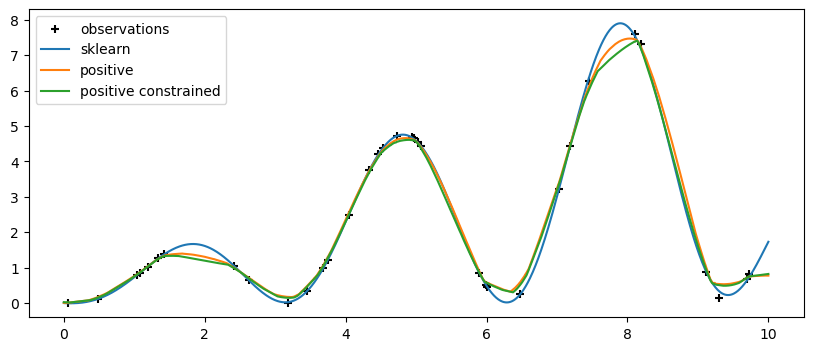

In [7]:
plt.figure(figsize=(10, 4))
plt.scatter(X_train, y_train, label="observations", c='k', marker='+')
plt.plot(X, prediction_1, label="sklearn")
plt.plot(X, prediction_2, label="positive")
plt.plot(X, prediction_3, label="positive constrained")
plt.legend()
plt.show()